In [1]:
%load_ext tensorboard

In [2]:
import os
import datetime

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.integrate import solve_ivp
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor

from assets.ml.DeepONetwork import TrunkNN
from assets.ml.DeepONetwork import BranchNN
from assets.ml.DeepONetwork import DeepONET
from assets.ml.DeepONetwork import DeepOPINN

2023-12-10 19:19:15.065631: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
log_dir = os.path.join(".", "assets", "logs", "fits", f"{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True, profile_batch=True, )

2023-12-10 19:19:24.951325: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-12-10 19:19:24.951345: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2023-12-10 19:19:24.952320: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


In [4]:
def createSamples(lengthScale, k, domain):
    kernel = RBF(length_scale=lengthScale)
    GP = GaussianProcessRegressor(kernel=kernel)
    u_sample = np.zeros((k, 100))
    for i in range(k):
        n = np.random.randint(0, 10000)
        u_sample[i, :] = GP.sample_y(domain.reshape(-1, 1), random_state=n).flatten()

    return u_sample

In [5]:
domain = np.linspace(0, 1, 100)
U = createSamples(lengthScale=0.2, k=1000, domain=domain)
print(U.shape)

(1000, 100)


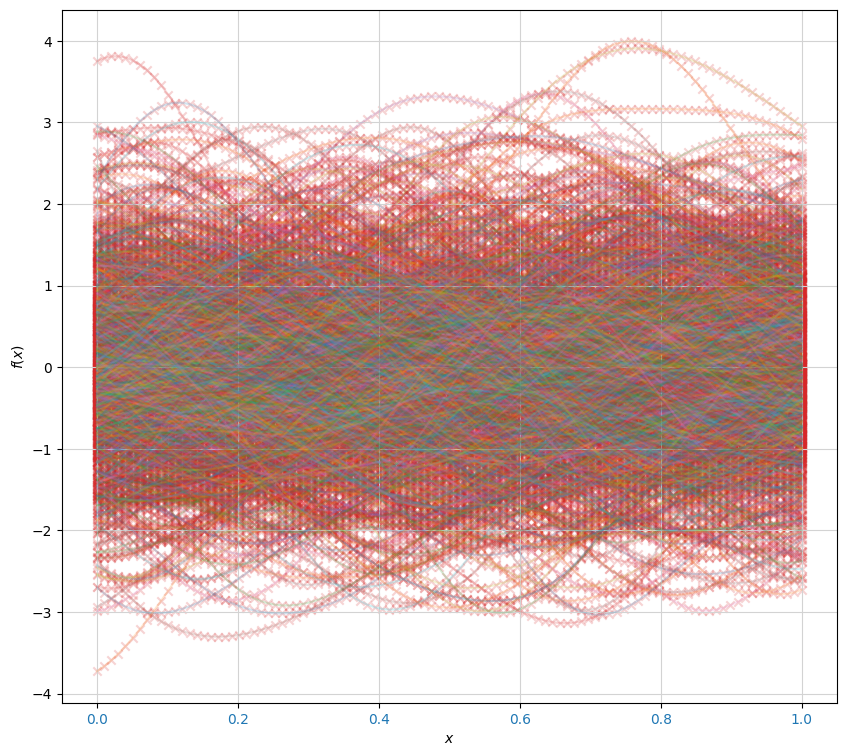

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 9))

for u in U:
    ax.plot(domain, u, alpha = 0.2)
    ax.scatter(domain, u, marker = "x", color = "tab:red", alpha=0.2)

ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$")
ax.tick_params(axis='x', labelcolor = 'tab:blue')
ax.grid(True, color='lightgrey')

plt.show()

In [7]:
def solutions(u, t):
    sols = []
    for i in tqdm(range(u.shape[0]), desc="Generating Solutions", ncols=90):
        sol = solve_ivp(lambda var_t, var_s: np.interp(var_t, t.flatten(), u[i, :]), t_span=[0, 1], y0=[0], t_eval=t.flatten(), method='RK45')
        sols.append(sol.y[0].reshape(-1, 1))

    return np.array(sols)

In [8]:
Y = solutions(u=U, t=domain.reshape(-1, 1))
print(Y.shape)

Generating Solutions: 100%|██████████████████████████| 1000/1000 [00:03<00:00, 276.99it/s]

(1000, 100, 1)


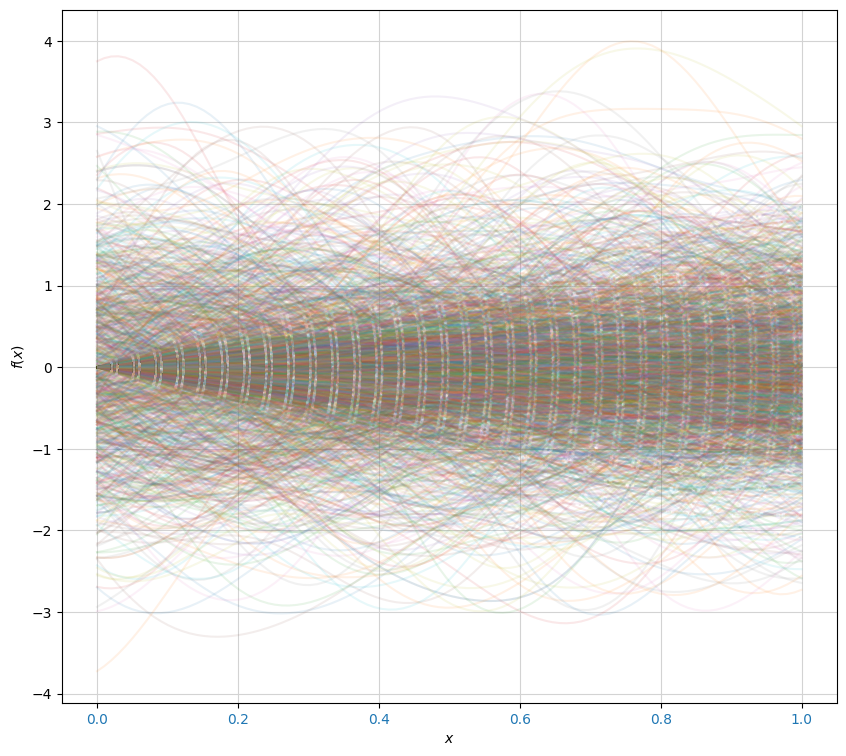

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 9))

for u in U:
    ax.plot(domain, u, alpha=0.1)

for y in Y:
    ax.plot(domain, y, linestyle = "-.", alpha = 0.1)

ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$")
ax.tick_params(axis='x', labelcolor = 'tab:blue')
ax.grid(True, color='lightgrey')

plt.show()

In [10]:
branchHiddenLayers = [tf.keras.layers.Dense(20, activation = 'tanh', name = f"branchNETDense_layer{i+1}") for i in range(5)]
trunkHiddenLayers = [tf.keras.layers.Dense(20, activation = 'tanh', name = f"trunkNETDense_layer{i+1}") for i in range(5)]


branchNET = BranchNN(hiddenLayers=branchHiddenLayers, input_shape=(100,))
trunkNET = TrunkNN(hiddenLayers=trunkHiddenLayers, input_shape=(1,))
deepONET = DeepONET(branchNN=branchNET, trunkNN=trunkNET)

In [11]:
domain = np.linspace(0, 1, 100)

In [12]:
n = 1000

U = createSamples(lengthScale=0.2, k=n, domain=domain)

print(U.shape)
branch_input = []
for u in U:
    for t in domain:
        branch_input.append(u)
branch_input = np.array(branch_input)
print(branch_input.shape)

trunk_input = np.array([domain for i in range(n)]).reshape(-1, 1)
print(trunk_input.shape)

y = solutions(u=U, t=domain.reshape(-1, 1)).reshape(-1, 1)
print(y.shape)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999)
deepONET.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

(1000, 100)
(100000, 100)
(100000, 1)


Generating Solutions: 100%|██████████████████████████| 1000/1000 [00:02<00:00, 448.64it/s]


(100000, 1)


In [13]:
deepONET.build(input_shape=[(None, 100), (None, 1)])

Branch Input Shape: (None, 100)
Trunk Input Shape: (None, 1)
Branch Output Shape: (None, 20)
Trunk Output Shape: (None, 20)
Dot Product Output Shape: (None, 1)
Output Shape: (None, 1)
Branch Input Shape: (None, 100)
Trunk Input Shape: (None, 1)
Branch Output Shape: (None, 20)
Trunk Output Shape: (None, 20)
Dot Product Output Shape: (None, 1)
Output Shape: (None, 1)


In [14]:
deepONET.summary()

Model: "deep_onet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 branch_nn (BranchNN)        multiple                  4120      
                                                                 
 trunk_nn (TrunkNN)          multiple                  2140      
                                                                 
 bias_layer (BiasLayer)      multiple                  1         
                                                                 
Total params: 6261 (24.46 KB)
Trainable params: 6261 (24.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
deepONET.fit(x=[branch_input, trunk_input], y=y, epochs=15, verbose=True, batch_size=100, validation_split=0.3, callbacks=tensorboard_callback)

Epoch 1/15
Branch Input Shape: (100, 100)
Trunk Input Shape: (100, 1)
Branch Output Shape: (100, 20)
Trunk Output Shape: (100, 20)
Dot Product Output Shape: (100, 1)
Output Shape: (100, 1)


2023-12-10 19:19:50.548497: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-12-10 19:19:50.548515: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.


 12/700 [..............................] - ETA: 3s - loss: 0.0519 - mae: 0.1675   

2023-12-10 19:19:53.884636: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2023-12-10 19:19:53.996980: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2023-12-10 19:19:54.001763: I tensorflow/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: ./assets/logs/fits/20231210-191924/plugins/profile/2023_12_10_19_19_53/bmbp.modem.xplane.pb


700/700 [==============================] - 8s 6ms/step - loss: 0.0091 - mae: 0.0679 - val_loss: 0.0038 - val_mae: 0.0467
Epoch 2/15
700/700 [==============================] - 3s 4ms/step - loss: 0.0035 - mae: 0.0453 - val_loss: 0.0044 - val_mae: 0.0503
Epoch 3/15
700/700 [==============================] - 3s 4ms/step - loss: 0.0029 - mae: 0.0409 - val_loss: 0.0027 - val_mae: 0.0395
Epoch 4/15
700/700 [==============================] - 3s 4ms/step - loss: 0.0011 - mae: 0.0254 - val_loss: 8.2011e-04 - val_mae: 0.0216
Epoch 5/15
700/700 [==============================] - 6s 8ms/step - loss: 9.7965e-04 - mae: 0.0238 - val_loss: 9.8844e-04 - val_mae: 0.0242
Epoch 6/15
700/700 [==============================] - 3s 5ms/step - loss: 8.7976e-04 - mae: 0.0225 - val_loss: 0.0010 - val_mae: 0.0245
Epoch 7/15
700/700 [==============================] - 3s 5ms/step - loss: 9.0261e-04 - mae: 0.0228 - val_loss: 9.4905e-04 - val_mae: 0.0232
Epoch 8/15
700/700 [==============================] - 3s 4ms/st

In [16]:
%tensorboard --logdir ./assets/logs --port=8080

In [17]:
testDomain = np.linspace(0, 1, 100)
testU = createSamples(lengthScale=0.2, k=1, domain=testDomain)
groundTruth = solutions(u=testU, t=testDomain).reshape(-1, 1)

print(testDomain.shape)
print(testU.shape)
print(groundTruth.shape)

Generating Solutions: 100%|████████████████████████████████| 1/1 [00:00<00:00, 204.46it/s]

(100,)
(1, 100)
(100, 1)


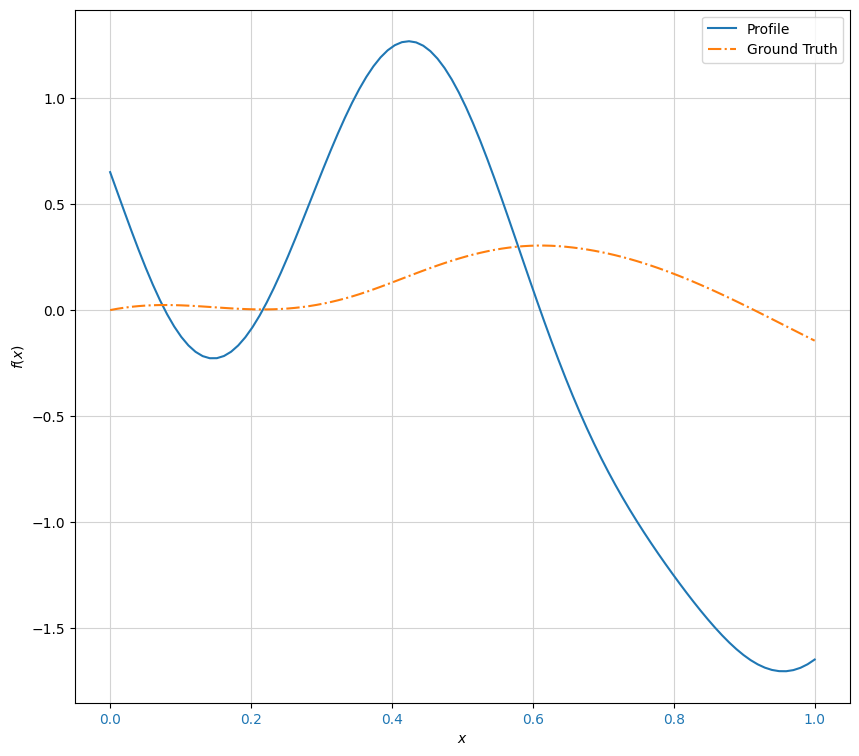

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 9))

ax.plot(testDomain, testU.reshape(100, ), label = "Profile")
ax.plot(testDomain, groundTruth, linestyle = "-.", label = "Ground Truth")

ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$")
ax.tick_params(axis='x', labelcolor = 'tab:blue')
ax.legend()
ax.grid(True, color='lightgrey')

plt.show()

In [19]:
testBranchInput = np.array([testU for i in range(testDomain.shape[0])]).reshape(-1, 100)
print(testBranchInput.shape)
testTrunkInput = testDomain.reshape(-1, 1)
print(testTrunkInput.shape)

preds = deepONET.predict([testBranchInput, testTrunkInput])
print(preds.shape)

(100, 100)
(100, 1)
Branch Input Shape: (None, 100)
Trunk Input Shape: (None, 1)
Branch Output Shape: (None, 20)
Trunk Output Shape: (None, 20)
Dot Product Output Shape: (None, 1)
Output Shape: (None, 1)
4/4 [==============================] - 0s 2ms/step
(100, 1)


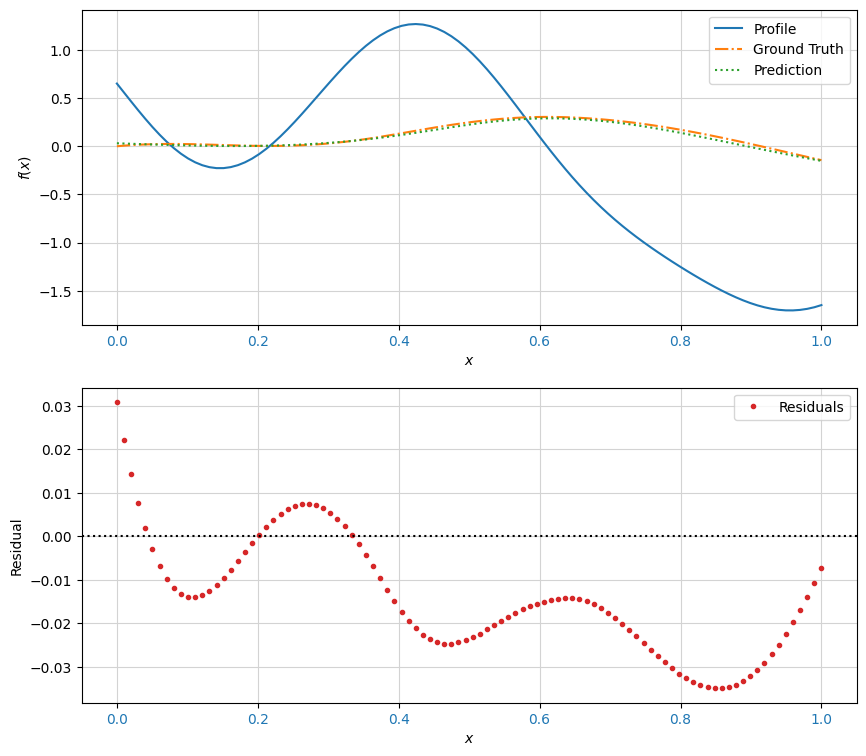

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(10, 9))

ax[0].plot(testDomain, testU.reshape(100, ), label = "Profile")
ax[0].plot(testDomain, groundTruth, linestyle = "-.", label = "Ground Truth")
ax[0].plot(testDomain, preds.reshape(100, ), linestyle = ":", label = "Prediction")

ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$f(x)$")
ax[0].tick_params(axis='x', labelcolor = 'tab:blue')
ax[0].legend()
ax[0].grid(True, color='lightgrey')

ax[1].plot(testDomain, preds - groundTruth, ".", color = "tab:red", label = "Residuals")
ax[1].axhline(0, linestyle = ":", color = "k")

ax[1].set_xlabel("$x$")
ax[1].set_ylabel("Residual")
ax[1].tick_params(axis='x', labelcolor = 'tab:blue')
ax[1].legend()
ax[1].grid(True, color='lightgrey')

plt.show()

In [21]:
branchOutput = deepONET.branchNN(testBranchInput)
print(branchOutput.shape)

trunkOutput = deepONET.trunkNN(testTrunkInput)
print(trunkOutput.shape)

(100, 20)
(100, 20)


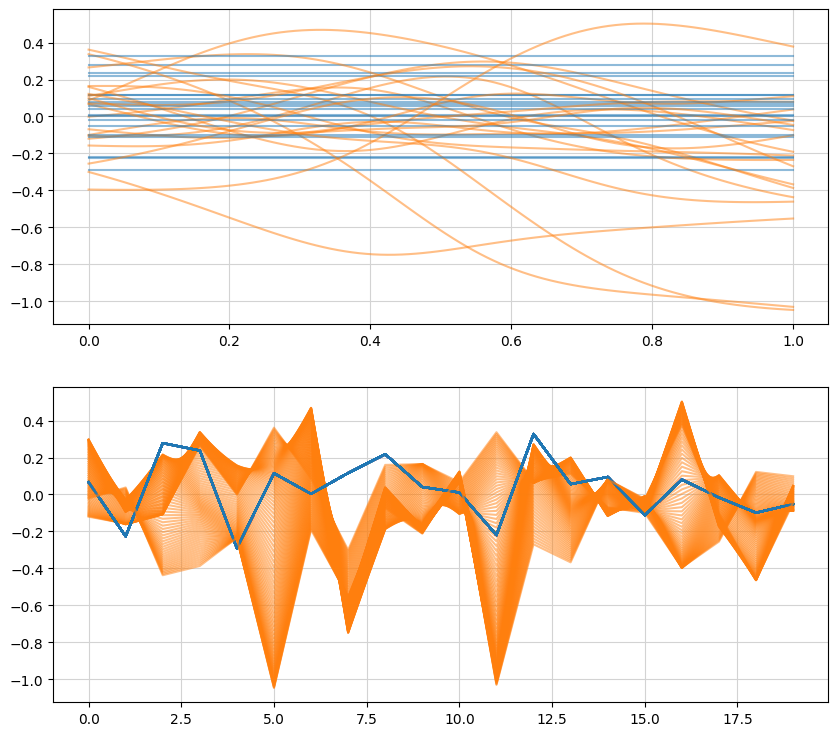

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(10,9))

for i in range(20):
    ax[0].plot(testDomain, branchOutput[:, i], '-', color = "C0", alpha = 0.5)
    ax[0].plot(testDomain, trunkOutput[:, i], '-', color = "C1", alpha = 0.5)

ax[0].grid(True, color = 'lightgrey')

for i in range(100):
    ax[1].plot(branchOutput[i, :], '-', color = "C0", alpha = 0.5)
    ax[1].plot(trunkOutput[i, :], '-', color = "C1", alpha = 0.5)

ax[1].grid(True, color = 'lightgrey')

plt.show()

In [23]:
testDomain = np.linspace(0, 1, 100)
testU = createSamples(lengthScale=0.05, k=1, domain=testDomain)
groundTruth = solutions(u=testU, t=testDomain).reshape(-1, 1)

print(testDomain.shape)
print(testU.shape)
print(groundTruth.shape)

Generating Solutions: 100%|█████████████████████████████████| 1/1 [00:00<00:00, 99.93it/s]

(100,)
(1, 100)
(100, 1)


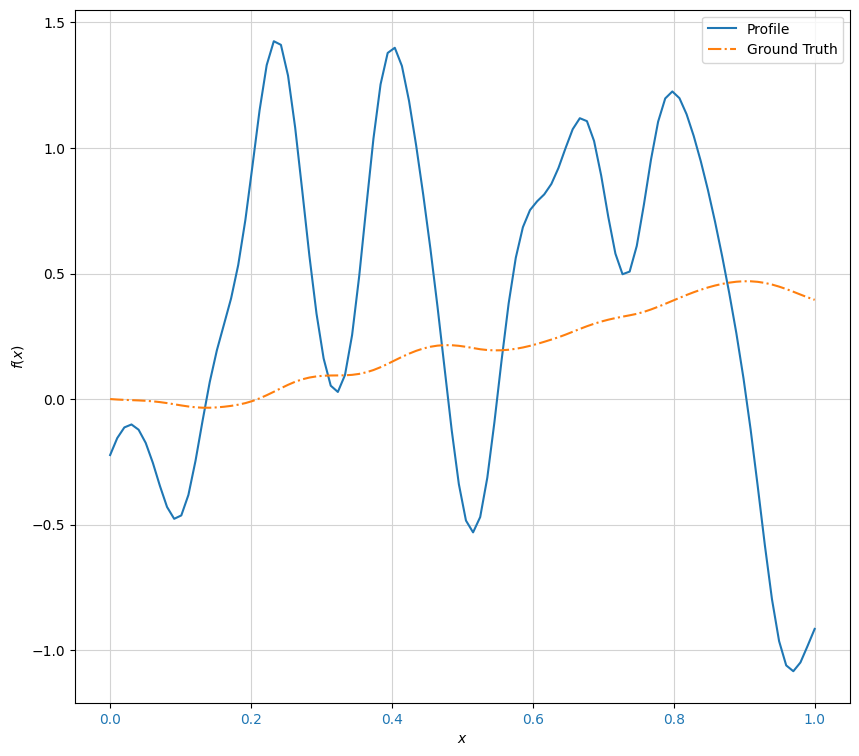

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 9))

ax.plot(testDomain, testU.reshape(100, ), label = "Profile")
ax.plot(testDomain, groundTruth, linestyle = "-.", label = "Ground Truth")

ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$")
ax.tick_params(axis='x', labelcolor = 'tab:blue')
ax.legend()
ax.grid(True, color='lightgrey')

plt.show()

In [25]:
testBranchInput = np.array([testU for i in range(testDomain.shape[0])]).reshape(-1, 100)
print(testBranchInput.shape)
testTrunkInput = testDomain.reshape(-1, 1)
print(testTrunkInput.shape)

preds = deepONET.predict([testBranchInput, testTrunkInput])
print(preds.shape)

(100, 100)
(100, 1)
4/4 [==============================] - 0s 2ms/step
(100, 1)


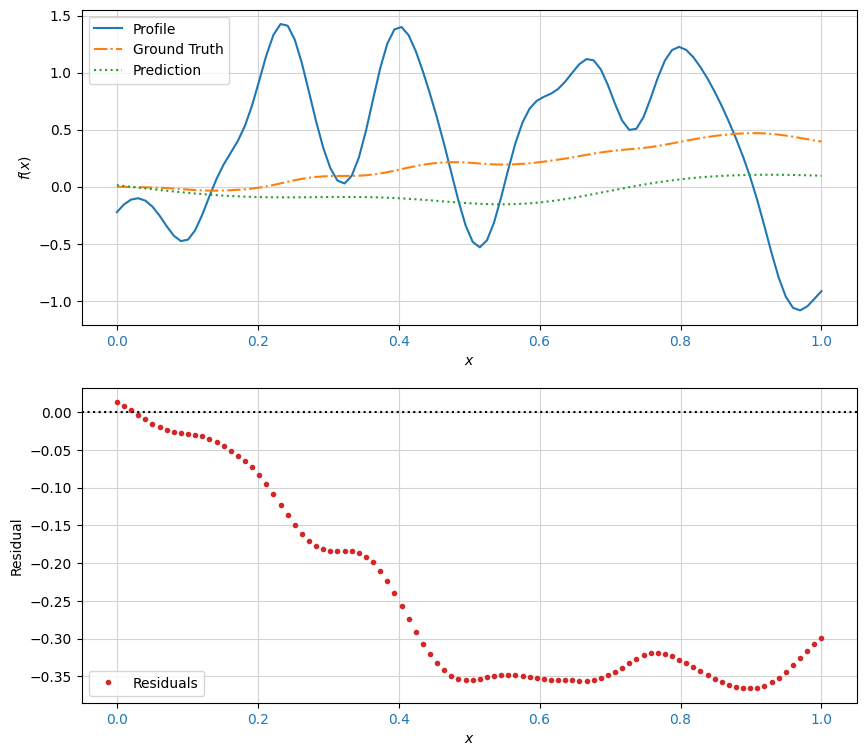

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(10, 9))

ax[0].plot(testDomain, testU.reshape(100, ), label = "Profile")
ax[0].plot(testDomain, groundTruth, linestyle = "-.", label = "Ground Truth")
ax[0].plot(testDomain, preds.reshape(100, ), linestyle = ":", label = "Prediction")

ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$f(x)$")
ax[0].tick_params(axis='x', labelcolor = 'tab:blue')
ax[0].legend()
ax[0].grid(True, color='lightgrey')

ax[1].plot(testDomain, preds - groundTruth, ".", color = "tab:red", label = "Residuals")
ax[1].axhline(0, linestyle = ":", color = "k")

ax[1].set_xlabel("$x$")
ax[1].set_ylabel("Residual")
ax[1].tick_params(axis='x', labelcolor = 'tab:blue')
ax[1].legend()
ax[1].grid(True, color='lightgrey')

plt.show()

In [27]:
branchOutput = deepONET.branchNN(testBranchInput)
print(branchOutput.shape)

trunkOutput = deepONET.trunkNN(testTrunkInput)
print(trunkOutput.shape)

(100, 20)
(100, 20)


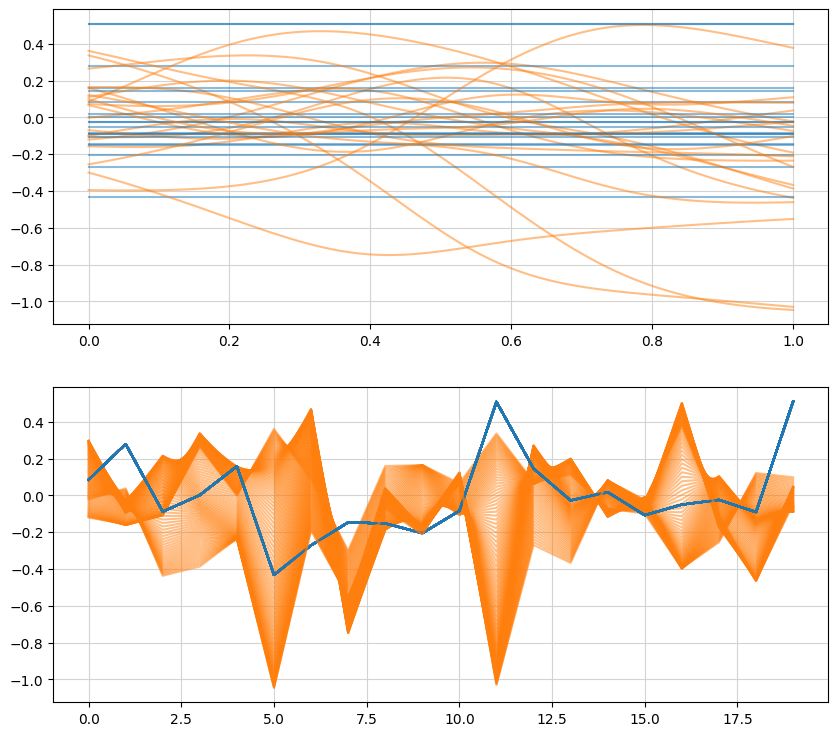

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(10,9))

for i in range(20):
    ax[0].plot(testDomain, branchOutput[:, i], '-', color = "C0", alpha = 0.5)
    ax[0].plot(testDomain, trunkOutput[:, i], '-', color = "C1", alpha = 0.5)

ax[0].grid(True, color = 'lightgrey')

for i in range(100):
    ax[1].plot(branchOutput[i, :], '-', color = "C0", alpha = 0.5)
    ax[1].plot(trunkOutput[i, :], '-', color = "C1", alpha = 0.5)

ax[1].grid(True, color = 'lightgrey')

plt.show()

In [29]:
branchHiddenLayers = [tf.keras.layers.Dense(20, activation = 'tanh', name = f"branchNETPINN_layer{i+1}") for i in range(5)]
trunkHiddenLayers = [tf.keras.layers.Dense(20, activation = 'tanh', name = f"trunkNETPINN_layer{i+1}") for i in range(5)]

branchNET = BranchNN(hiddenLayers=branchHiddenLayers, input_shape=(100,))
trunkNET = TrunkNN(hiddenLayers=trunkHiddenLayers, input_shape=(1,))
deepOPINN = DeepOPINN(branchNN=branchNET, trunkNN=trunkNET)

In [30]:
domain = np.linspace(0, 1, 100)

In [31]:
n = 1000

U = createSamples(lengthScale=0.2, k=n, domain=domain)

print(U.shape)
branch_input = []
for u in U:
    for t in domain:
        branch_input.append(u)
branch_input = np.array(branch_input)
print(branch_input.shape)

trunk_input = np.array([domain for i in range(n)]).reshape(-1, 1)
print(trunk_input.shape)

y = solutions(u=U, t=domain.reshape(-1, 1)).reshape(-1, 1)
print(y.shape)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999)
deepOPINN.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

(1000, 100)
(100000, 100)
(100000, 1)


Generating Solutions: 100%|██████████████████████████| 1000/1000 [00:02<00:00, 436.79it/s]

(100000, 1)


In [32]:
deepOPINN.build(input_shape=[(None, 100), (None, 1)])

Branch Input Shape: (None, 100)
Trunk Input Shape: (None, 1)
Branch Output Shape: (None, 20)
Trunk Output Shape: (None, 20)
Dot Product Output Shape: (None, 1)
Output Shape: (None, 1)
Branch Input Shape: (None, 100)
Trunk Input Shape: (None, 1)
Branch Output Shape: (None, 20)
Trunk Output Shape: (None, 20)
Dot Product Output Shape: (None, 1)
Output Shape: (None, 1)


In [33]:
deepOPINN.summary()

Model: "deep_opinn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 branch_nn_1 (BranchNN)      multiple                  4120      
                                                                 
 trunk_nn_1 (TrunkNN)        multiple                  2140      
                                                                 
 bias_layer_1 (BiasLayer)    multiple                  1         
                                                                 
Total params: 6261 (24.46 KB)
Trainable params: 6261 (24.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
deepOPINN.fit(x=[branch_input, trunk_input], y=y, epochs=15, verbose=True, batch_size=100, validation_split=0.3, callbacks=tensorboard_callback)

Epoch 1/15


2023-12-10 19:21:08.616392: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-12-10 19:21:08.616419: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.


Branch Input Shape: (100, 100)
Trunk Input Shape: (100, 1)
Branch Output Shape: (100, 20)
Trunk Output Shape: (100, 20)
Dot Product Output Shape: (100, 1)
Output Shape: (100, 1)


2023-12-10 19:21:28.665272: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.


 32/700 [>.............................] - ETA: 3s - loss: 0.0622   

2023-12-10 19:21:30.091078: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2023-12-10 19:21:30.091492: I tensorflow/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: ./assets/logs/fits/20231210-191924/plugins/profile/2023_12_10_19_21_30/bmbp.modem.xplane.pb


700/700 [==============================] - 26s 6ms/step - loss: 0.0273 - val_loss: 0.0195 - val_mae: 0.1085
Epoch 2/15
700/700 [==============================] - 5s 7ms/step - loss: 0.0211 - val_loss: 0.0181 - val_mae: 0.1052
Epoch 3/15
700/700 [==============================] - 5s 7ms/step - loss: 0.0200 - val_loss: 0.0141 - val_mae: 0.0928
Epoch 4/15
700/700 [==============================] - 5s 8ms/step - loss: 0.0199 - val_loss: 0.0132 - val_mae: 0.0899
Epoch 5/15
700/700 [==============================] - 5s 7ms/step - loss: 0.0194 - val_loss: 0.0192 - val_mae: 0.1061
Epoch 6/15
700/700 [==============================] - 4s 5ms/step - loss: 0.0193 - val_loss: 0.0154 - val_mae: 0.0964
Epoch 7/15
700/700 [==============================] - 4s 6ms/step - loss: 0.0191 - val_loss: 0.0141 - val_mae: 0.0943
Epoch 8/15
700/700 [==============================] - 4s 5ms/step - loss: 0.0196 - val_loss: 0.0142 - val_mae: 0.0930
Epoch 9/15
700/700 [==============================] - 4s 5ms/step 

In [35]:
testDomain = np.linspace(0, 1, 100)
testU = createSamples(lengthScale=0.2, k=1, domain=testDomain)
groundTruth = solutions(u=testU, t=testDomain).reshape(-1, 1)

print(testDomain.shape)
print(testU.shape)
print(groundTruth.shape)

Generating Solutions:   0%|                                         | 0/1 [00:00<?, ?it/s]

Generating Solutions: 100%|████████████████████████████████| 1/1 [00:00<00:00, 129.25it/s]

(100,)
(1, 100)
(100, 1)


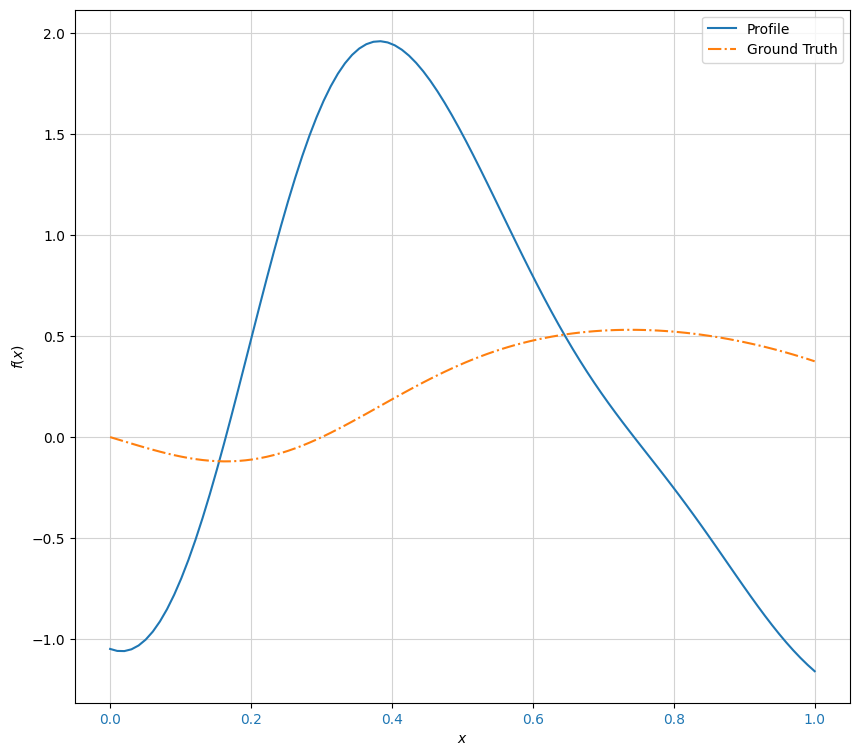

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10, 9))

ax.plot(testDomain, testU.reshape(100, ), label = "Profile")
ax.plot(testDomain, groundTruth, linestyle = "-.", label = "Ground Truth")

ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$")
ax.tick_params(axis='x', labelcolor = 'tab:blue')
ax.legend()
ax.grid(True, color='lightgrey')

plt.show()

In [37]:
testBranchInput = np.array([testU for i in range(testDomain.shape[0])]).reshape(-1, 100)
print(testBranchInput.shape)
testTrunkInput = testDomain.reshape(-1, 1)
print(testTrunkInput.shape)

preds = deepOPINN.predict([testBranchInput, testTrunkInput])
print(preds.shape)

(100, 100)
(100, 1)
Branch Input Shape: (None, 100)
Trunk Input Shape: (None, 1)
Branch Output Shape: (None, 20)
Trunk Output Shape: (None, 20)
Dot Product Output Shape: (None, 1)
Output Shape: (None, 1)
4/4 [==============================] - 0s 2ms/step
(100, 1)


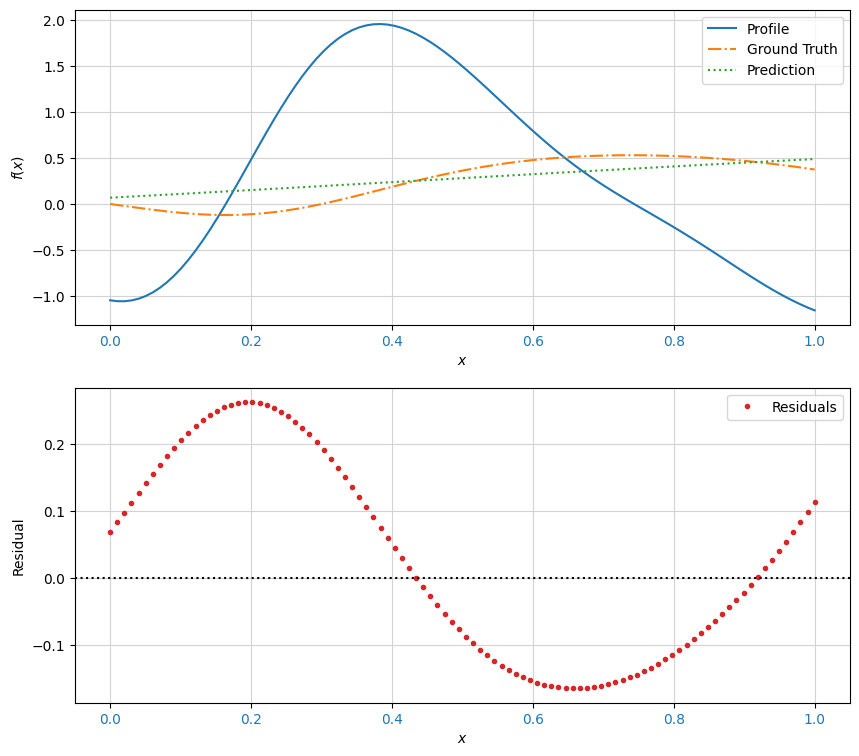

In [38]:
fig, ax = plt.subplots(2, 1, figsize=(10, 9))

ax[0].plot(testDomain, testU.reshape(100, ), label = "Profile")
ax[0].plot(testDomain, groundTruth, linestyle = "-.", label = "Ground Truth")
ax[0].plot(testDomain, preds.reshape(100, ), linestyle = ":", label = "Prediction")

ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$f(x)$")
ax[0].tick_params(axis='x', labelcolor = 'tab:blue')
ax[0].legend()
ax[0].grid(True, color='lightgrey')

ax[1].plot(testDomain, preds - groundTruth, ".", color = "tab:red", label = "Residuals")
ax[1].axhline(0, linestyle = ":", color = "k")

ax[1].set_xlabel("$x$")
ax[1].set_ylabel("Residual")
ax[1].tick_params(axis='x', labelcolor = 'tab:blue')
ax[1].legend()
ax[1].grid(True, color='lightgrey')

plt.show()

In [39]:
branchOutput = deepONET.branchNN(testBranchInput)
print(branchOutput.shape)

trunkOutput = deepONET.trunkNN(testTrunkInput)
print(trunkOutput.shape)

(100, 20)
(100, 20)


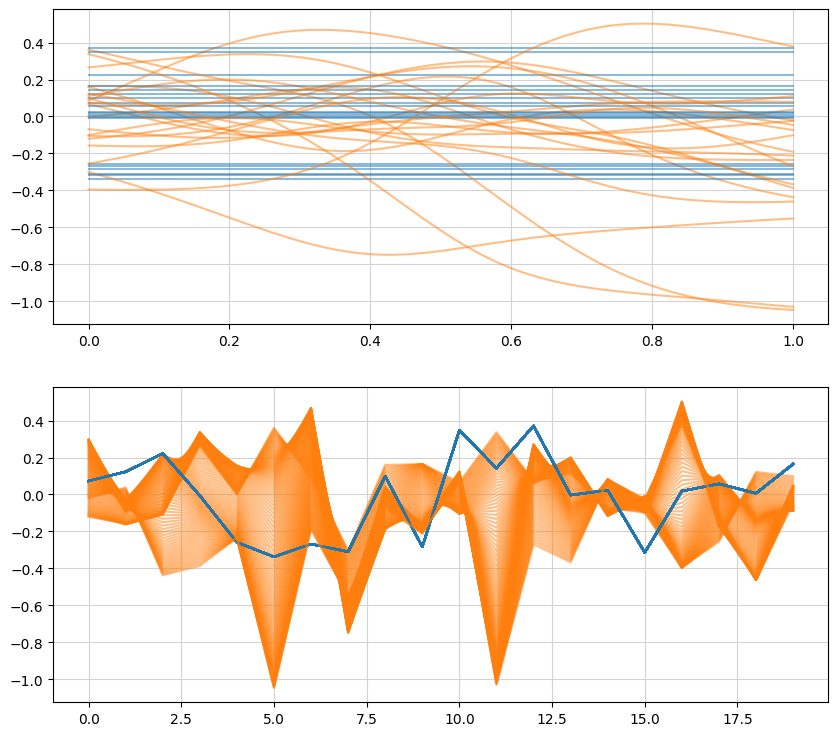

In [40]:
fig, ax = plt.subplots(2, 1, figsize=(10,9))

for i in range(20):
    ax[0].plot(testDomain, branchOutput[:, i], '-', color = "C0", alpha = 0.5)
    ax[0].plot(testDomain, trunkOutput[:, i], '-', color = "C1", alpha = 0.5)

ax[0].grid(True, color = 'lightgrey')

for i in range(100):
    ax[1].plot(branchOutput[i, :], '-', color = "C0", alpha = 0.5)
    ax[1].plot(trunkOutput[i, :], '-', color = "C1", alpha = 0.5)

ax[1].grid(True, color = 'lightgrey')

plt.show()

In [41]:
testDomain = np.linspace(0, 1, 100)
testU = createSamples(lengthScale=0.05, k=1, domain=testDomain)
groundTruth = solutions(u=testU, t=testDomain).reshape(-1, 1)

print(testDomain.shape)
print(testU.shape)
print(groundTruth.shape)

Generating Solutions: 100%|█████████████████████████████████| 1/1 [00:00<00:00, 78.61it/s]

(100,)
(1, 100)
(100, 1)


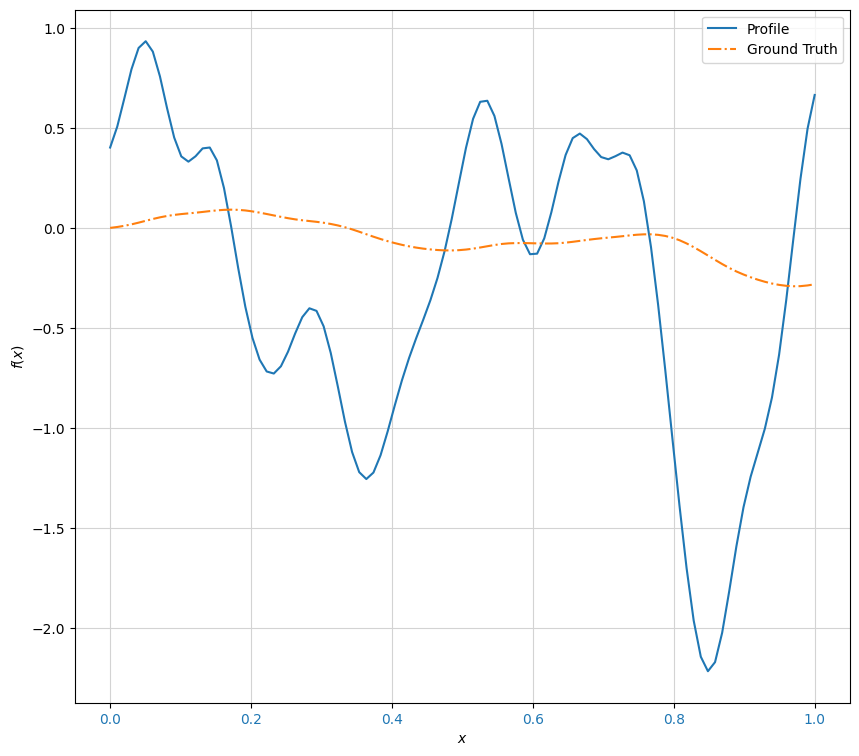

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10, 9))

ax.plot(testDomain, testU.reshape(100, ), label = "Profile")
ax.plot(testDomain, groundTruth, linestyle = "-.", label = "Ground Truth")

ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$")
ax.tick_params(axis='x', labelcolor = 'tab:blue')
ax.legend()
ax.grid(True, color='lightgrey')

plt.show()

In [43]:
testBranchInput = np.array([testU for i in range(testDomain.shape[0])]).reshape(-1, 100)
print(testBranchInput.shape)
testTrunkInput = testDomain.reshape(-1, 1)
print(testTrunkInput.shape)

preds = deepONET.predict([testBranchInput, testTrunkInput])
print(preds.shape)

(100, 100)
(100, 1)
4/4 [==============================] - 0s 17ms/step
(100, 1)


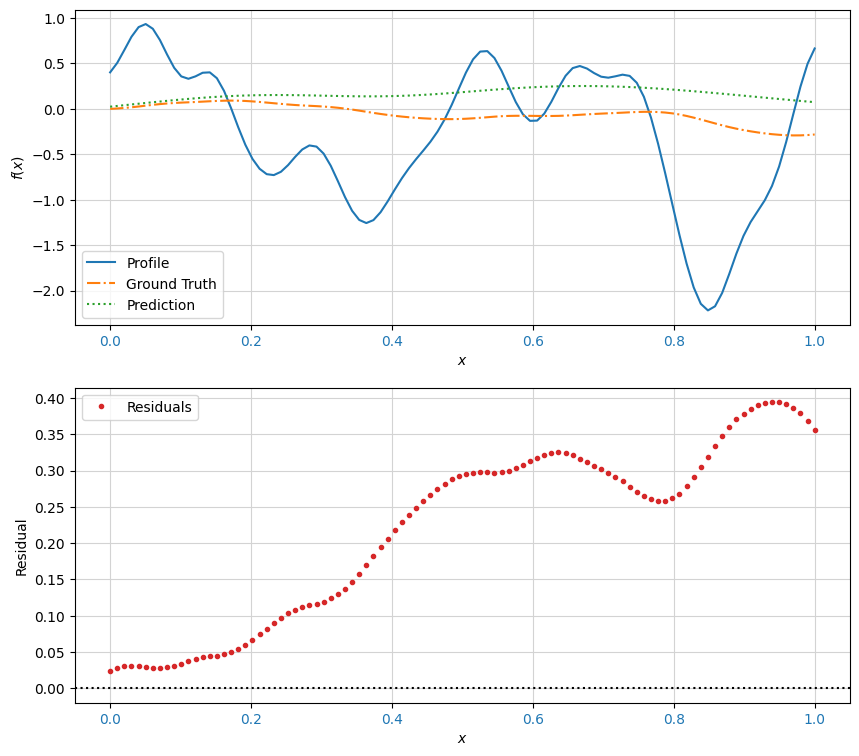

In [44]:
fig, ax = plt.subplots(2, 1, figsize=(10, 9))

ax[0].plot(testDomain, testU.reshape(100, ), label = "Profile")
ax[0].plot(testDomain, groundTruth, linestyle = "-.", label = "Ground Truth")
ax[0].plot(testDomain, preds.reshape(100, ), linestyle = ":", label = "Prediction")

ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$f(x)$")
ax[0].tick_params(axis='x', labelcolor = 'tab:blue')
ax[0].legend()
ax[0].grid(True, color='lightgrey')

ax[1].plot(testDomain, preds - groundTruth, ".", color = "tab:red", label = "Residuals")
ax[1].axhline(0, linestyle = ":", color = "k")

ax[1].set_xlabel("$x$")
ax[1].set_ylabel("Residual")
ax[1].tick_params(axis='x', labelcolor = 'tab:blue')
ax[1].legend()
ax[1].grid(True, color='lightgrey')

plt.show()

In [45]:
branchOutput = deepONET.branchNN(testBranchInput)
print(branchOutput.shape)

trunkOutput = deepONET.trunkNN(testTrunkInput)
print(trunkOutput.shape)

(100, 20)
(100, 20)


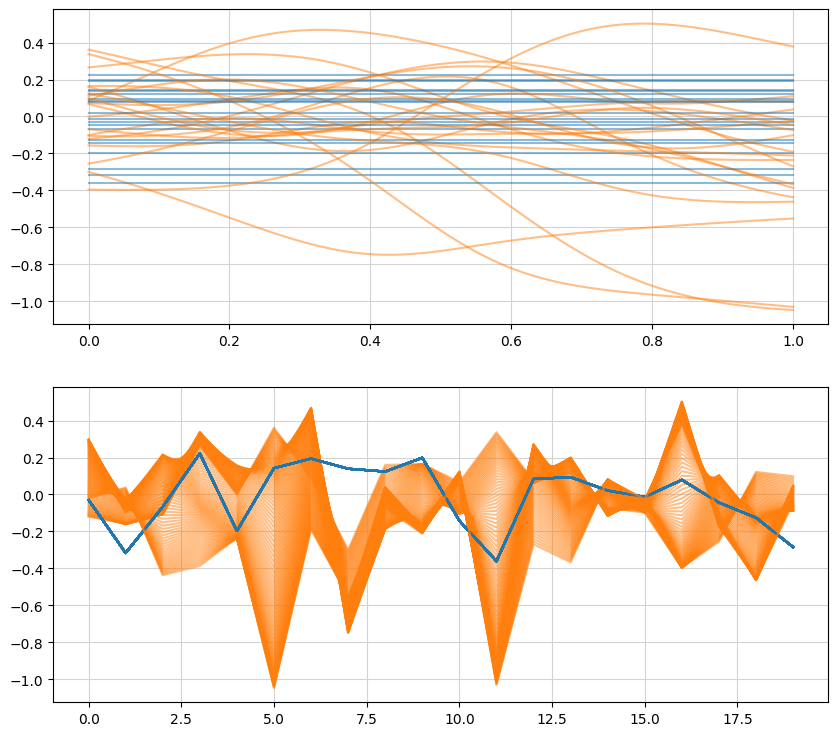

In [46]:
fig, ax = plt.subplots(2, 1, figsize=(10,9))

for i in range(20):
    ax[0].plot(testDomain, branchOutput[:, i], '-', color = "C0", alpha = 0.5)
    ax[0].plot(testDomain, trunkOutput[:, i], '-', color = "C1", alpha = 0.5)

ax[0].grid(True, color = 'lightgrey')

for i in range(100):
    ax[1].plot(branchOutput[i, :], '-', color = "C0", alpha = 0.5)
    ax[1].plot(trunkOutput[i, :], '-', color = "C1", alpha = 0.5)

ax[1].grid(True, color = 'lightgrey')

plt.show()